<a href="https://colab.research.google.com/github/AleR26/ColabFiles/blob/main/PracticaReduccionNumerosidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================================================
# 📝 Tarea: Reducción de la Numerosidad con CNN, ENN y K-medias usando SVM
# 📊 Dataset: Breast Cancer (Scikit-Learn)
# 👤 Autor/a: Alejandra Rivas
# 📅 Fecha: 17/11/2025
# ==========================================================================

## 🔍 Descripción:
En este cuaderno aplicarás técnicas de reducción de la numerosidad (CNN, ENN, K-medias) al conjunto de datos Breast Cancer y analizarás su efecto en el rendimiento de un modelo SVM.

## ==========================================================================

## 1. Cargar librerías necesarias
Escribe aquí la importación de librerías: numpy, pandas, matplotlib, seaborn, sklearn (datasets, model_selection, preprocessing, metrics, svm, kmeans), etc.

En el caso de los códigos de ENN, CNN, estos  deberás tomarlos del cuaderno que contiene la teoría y ejemplos.

In [6]:
#1. Cargar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------------

## 2. Cargar y explorar el conjunto de datos Breast Cancer
- Cargar el dataset con sklearn.datasets.load_breast_cancer
- Explora las dimensiones, variables, y distribución de clases

,count
1,357
0,212


/tmp/ipython-input-1153084950.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_names, y=class_distribution.values, palette='viridis')


([<matplotlib.axis.XTick at 0x7ed6538e4bc0>,
 [Text(0, 0, 'malignant'), Text(1, 0, 'benign')])

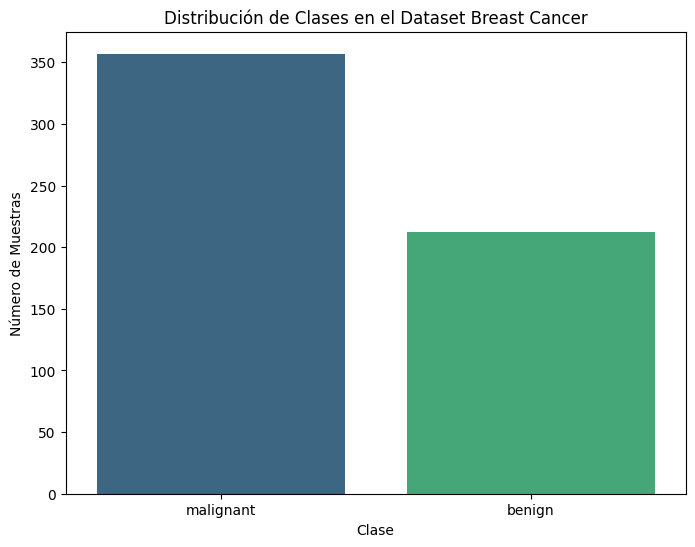

In [7]:
#2. Cargar y explorar el conjunto de datos Breast Cancer
# Paso 2: Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target
target_names = data.target_names
X

# Verificar la distribución de clases
class_distribution = pd.Series(y).value_counts()
display(class_distribution)

# Visualizar la distribución de clases
plt.figure(figsize=(8, 6))
sns.barplot(x=target_names, y=class_distribution.values, palette='viridis')
plt.title('Distribución de Clases en el Dataset Breast Cancer')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.xticks(ticks=[0, 1], labels=[target_names[0], target_names[1]])

# --------------------------------------------------------------------------

## 3. Preprocesamiento
 - Escalamiento de características (StandardScaler)
 - División del conjunto en entrenamiento y prueba
 - usar hold-out de 70% y 30%



In [8]:
# 3. Preprocesamiento
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------------------------------------------

## 4. Aplicar técnica CNN (Condensed Nearest Neighbor)

- Aplicar CNN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [9]:
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random

class CNN:
    """
    Condensed Nearest Neighbors (CNN) - versión adaptada para datos densos.

    Este algoritmo reduce el conjunto de entrenamiento reteniendo solo
    las instancias necesarias para preservar la capacidad de clasificación
    bajo la regla 1-NN (o k-NN si se ajusta n_neighbors).

    Basado en:
    P. E. Hart, The condensed nearest neighbor rule (1968).
    """

    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def select_data(self, X, y):
        # Validación de entrada: datos densos
        X, y = check_X_y(X, y, accept_sparse=False)

        idx_s = []  # índice de instancias seleccionadas
        classes = np.unique(y)
        self.classes_ = classes

        # Iniciar con una instancia aleatoria por clase
        for cur_class in classes:
            mask = np.where(y == cur_class)[0]
            choose_id = random.choice(mask)
            idx_s.append(choose_id)

        # Revisión aleatoria del resto de las instancias
        train_idx = list(range(len(y)))
        random.shuffle(train_idx)

        flag = True
        while flag:
            flag = False
            self.classifier.fit(X[idx_s], y[idx_s])
            for idx in train_idx:
                if idx not in idx_s:
                    x_i = X[idx].reshape(1, -1)
                    if self.classifier.predict(x_i) != [y[idx]]:
                        idx_s.append(idx)
                        self.classifier.fit(X[idx_s], y[idx_s])
                        flag = True

        self.X_ = X[idx_s]
        self.y_ = y[idx_s]
        self.sample_indices_ = sorted(idx_s)
        self.reduction_ = 1.0 - len(self.y_) / len(y)
        return self.X_, self.y_

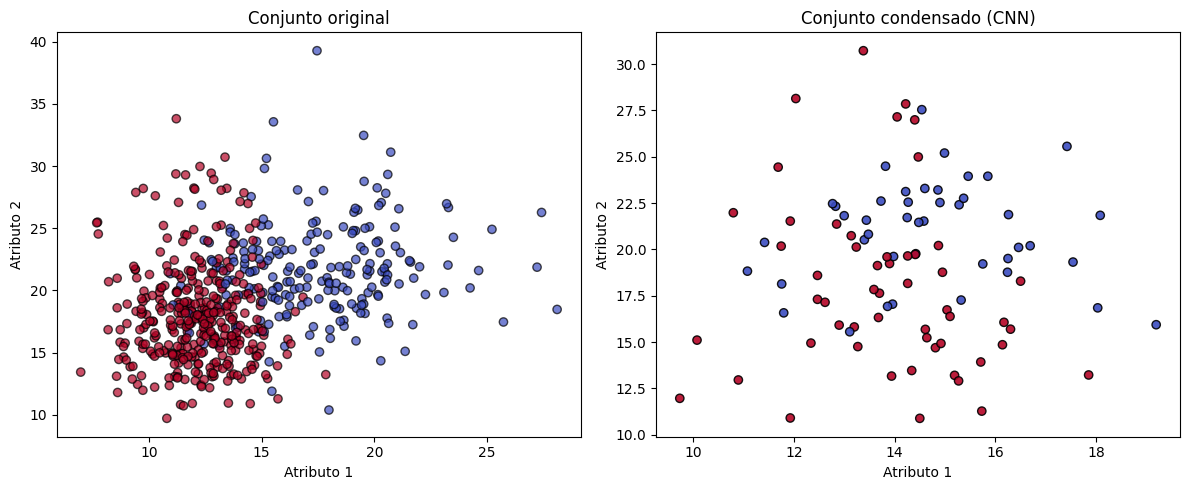

Instancias originales: 569
Instancias tras CNN:   96
Reducción: 83.13%


In [10]:
#4. Aplicar técnica CNN (Condensed Nearest Neighbor)
# Aplicar CNN
cnn = CNN(n_neighbors=1)
X_cnn, y_cnn = cnn.select_data(X, y)

# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_cnn[:, 0], X_cnn[:, 1], c=y_cnn, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto condensado (CNN)")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

print(f"Instancias originales: {len(y)}")
print(f"Instancias tras CNN:   {len(y_cnn)}")
print(f"Reducción: {100 * cnn.reduction_:.2f}%")

 --------------------------------------------------------------------------

## 5. Aplicar técnica ENN (Edited Nearest Neighbor)

- Aplicar ENN sobre el conjunto de entrenamiento
- Mostrar el tamaño del conjunto reducido



In [11]:
from sklearn.utils.validation import check_X_y
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random

class ENN:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.classifier = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.sample_indices_ = []

    def fit(self, X, y):
        # Validación inicial
        X, y = check_X_y(X, y, accept_sparse=False)

        mask = np.ones(len(y), dtype=bool)
        tmp_m = np.ones(len(y), dtype=bool)

        indices = list(range(len(y)))
        random.shuffle(indices)

        for i in indices:
            tmp_m[i] = False
            self.classifier.fit(X[tmp_m], y[tmp_m])
            x_i = X[i].reshape(1, -1)
            y_pred = self.classifier.predict(x_i)
            if y_pred[0] != y[i]:
                mask[i] = False
            tmp_m[i] = True

        self.X_ = X[mask]
        self.y_ = y[mask]
        self.sample_indices_ = np.where(mask)[0]
        self.reduction_ = 1 - len(self.y_) / len(y)
        return self

Original: 569 muestras
Limpio:   531 muestras


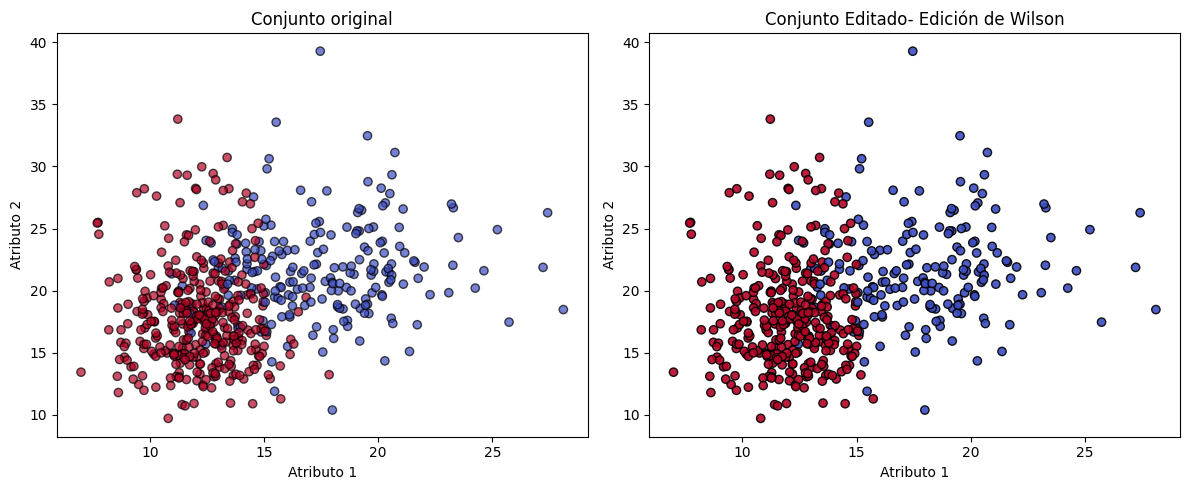

In [12]:
# 5. Aplicar técnica ENN (Edited Nearest Neighbor)
from sklearn.datasets import make_classification

# Aplicar ENN
selector = ENN(n_neighbors=5)
selector.fit(X, y)

# Seleccionar subconjunto
idx = selector.sample_indices_
X_clean, y_clean = X[idx], y[idx]

print(f"Original: {len(y)} muestras")
print(f"Limpio:   {len(y_clean)} muestras")


# Visualización
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title("Conjunto original")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.subplot(1, 2, 2)
plt.scatter(X_clean[:, 0], X_clean[:, 1], c=y_clean, cmap='coolwarm', edgecolor='k', alpha=0.9)
plt.title("Conjunto Editado- Edición de Wilson")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------

## 6. Aplicar reducción mediante K-medias
- Realizar agrupamiento por clase y representar cada grupo con su centroide. Elige la mitad de los elementos de cada clase como el valor del número de centroides
- Generar un nuevo conjunto reducido con los centroides como prototipos



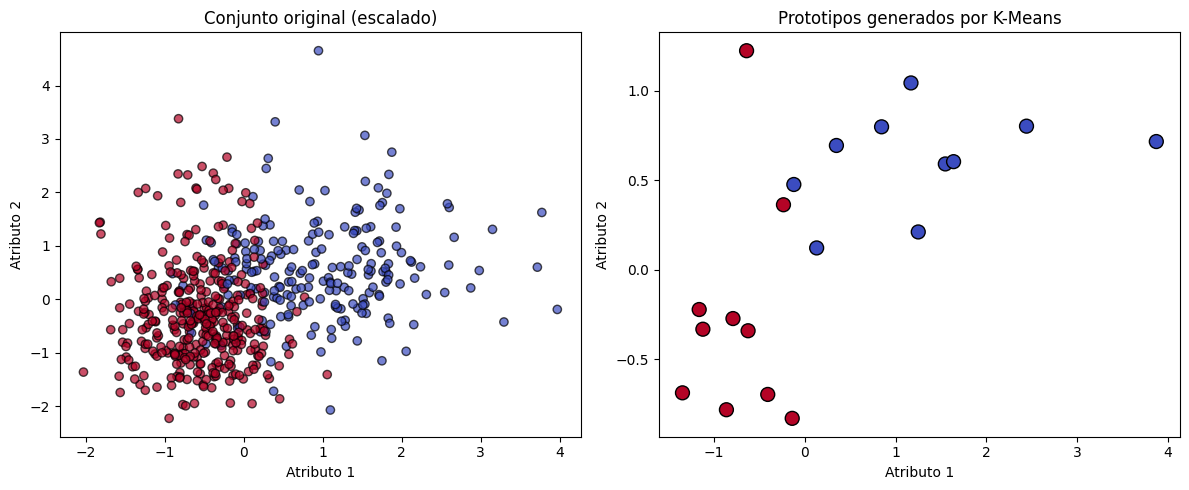

In [14]:
# 6. Aplicar reducción mediante K-medias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 2. Escalar los datos para mejor desempeño de KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Aquí puedes modificar el número de instancias por clase
# 3. Número de prototipos por clase
prototypes_per_class = 10
classes = np.unique(y)

# 4. Aplicar KMeans por clase
prototypes = []
labels = []

for c in classes:
    # Subconjunto de la clase actual
    class_data = X_scaled[y == c]

    # KMeans sobre los datos de la clase
    kmeans = KMeans(n_clusters=prototypes_per_class, random_state=42)
    kmeans.fit(class_data)

    # Guardar prototipos y sus etiquetas
    prototypes.append(kmeans.cluster_centers_)
    labels.extend([c] * prototypes_per_class)

# 5. Concatenar resultados
X_proto = np.vstack(prototypes)
y_proto = np.array(labels)

# 6. Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conjunto original
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
axes[0].set_title("Conjunto original (escalado)")
axes[0].set_xlabel("Atributo 1")
axes[0].set_ylabel("Atributo 2")

# Prototipos generados
axes[1].scatter(X_proto[:, 0], X_proto[:, 1], c=y_proto, cmap='coolwarm', edgecolor='k', s=100)
axes[1].set_title("Prototipos generados por K-Means")
axes[1].set_xlabel("Atributo 1")
axes[1].set_ylabel("Atributo 2")

plt.tight_layout()
plt.show()

 --------------------------------------------------------------------------

##7. Entrenar SVM sobre cada conjunto reducido
- Entrenar un modelo SVM (SVC) sobre:
 * los datos originales
 * datos reducidos con CNN
 * datos reducidos con ENN
 * datos reducidos con K-medias
- Evaluar cada modelo con accuracy, F1-score



In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

def train_and_evaluate_svm(X_train, y_train, X_test, y_test):

    svm_model = SVC(kernel='linear', random_state=42)

    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, f1

In [29]:
#7. Entrenar SVM sobre cada conjunto reducido

In [30]:
print('--- Entrenar SVM en datos originales ---')
accuracy_original, f1_original = train_and_evaluate_svm(X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Datos originales - Accuracy: {accuracy_original:.4f}, F1-score: {f1_original:.4f}")

results = {
    'Datos originales': {'Accuracy': accuracy_original, 'F1-score': f1_original}
}

--- Entrenar SVM en datos originales ---
Datos originales - Accuracy: 0.9766, F1-score: 0.9815


In [31]:
print('\n--- Entrenar SVM en datos reducidos con CNN  ---')
cnn_selector = CNN(n_neighbors=1)
X_train_cnn, y_train_cnn = cnn_selector.select_data(X_train_scaled, y_train)

print(f"CNN - Original: {len(y_train)}, Reducidos: {len(y_train_cnn)}")
accuracy_cnn, f1_cnn = train_and_evaluate_svm(X_train_cnn, y_train_cnn, X_test_scaled, y_test)
print(f"CNN datos reducidos - Accuracy: {accuracy_cnn:.4f}, F1-score: {f1_cnn:.4f}")

results['CNN Reduced Data'] = {'Accuracy': accuracy_cnn, 'F1-score': f1_cnn}


--- Entrenar SVM en datos reducidos con CNN  ---
CNN - Original: 398, Reducidos: 61
CNN datos reducidos - Accuracy: 0.9532, F1-score: 0.9626


In [32]:
print('--- Entrnenado SVM con datos reducidos con ENN ---')
enn_selector = ENN(n_neighbors=3)
enn_selector.fit(X_train_scaled, y_train)
X_train_enn, y_train_enn = enn_selector.X_, enn_selector.y_

print(f"ENN - Original: {len(y_train)}, Reduced Training: {len(y_train_enn)}")
accuracy_enn, f1_enn = train_and_evaluate_svm(X_train_enn, y_train_enn, X_test_scaled, y_test)
print(f"Datos reducidos con ENN - Accuracy: {accuracy_enn:.4f}, F1-score: {f1_enn:.4f}")

results['ENN Reduced Data'] = {'Accuracy': accuracy_enn, 'F1-score': f1_enn}

--- Entrnenado SVM con datos reducidos con ENN ---
ENN - Original: 398, Reduced Training: 383
Datos reducidos con ENN - Accuracy: 0.9883, F1-score: 0.9907


In [33]:
print('\n--- Entrenando SVM con datos ENN---')
enn_selector = ENN(n_neighbors=3)
enn_selector.fit(X_train_scaled, y_train)
X_train_enn, y_train_enn = enn_selector.X_, enn_selector.y_

print(f"ENN - Original: {len(y_train)}, Reduced Training: {len(y_train_enn)}")
accuracy_enn, f1_enn = train_and_evaluate_svm(X_train_enn, y_train_enn, X_test_scaled, y_test)
print(f"Datos reducidos ENN - Accuracy: {accuracy_enn:.4f}, F1-score: {f1_enn:.4f}")

results['ENN Reduced Data'] = {'Accuracy': accuracy_enn, 'F1-score': f1_enn}


--- Entrenando SVM con datos ENN---
ENN - Original: 398, Reduced Training: 383
Datos reducidos ENN - Accuracy: 0.9883, F1-score: 0.9907


In [34]:
print('\n--- SVM usando Kmeans---')

classes_in_train = np.unique(y_train)
prototypes_per_class_kmeans = {}
for c in classes_in_train:
    prototypes_per_class_kmeans[c] = max(1, len(y_train[y_train == c]) // 2)

X_train_kmeans = []
y_train_kmeans = []

for c in classes_in_train:
    class_data = X_train_scaled[y_train == c]
    n_clusters = prototypes_per_class_kmeans[c]

    if n_clusters > 0:
        n_clusters = min(n_clusters, len(class_data))

        if n_clusters > 0:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(class_data)
            X_train_kmeans.append(kmeans.cluster_centers_)
            y_train_kmeans.extend([c] * n_clusters)

X_train_kmeans = np.vstack(X_train_kmeans)
y_train_kmeans = np.array(y_train_kmeans)

print(f"K-Means - Original Training Samples: {len(y_train)}, Reduced Training Samples: {len(y_train_kmeans)}")
accuracy_kmeans, f1_kmeans = train_and_evaluate_svm(X_train_kmeans, y_train_kmeans, X_test_scaled, y_test)
print(f"K-Means Reduced Data - Accuracy: {accuracy_kmeans:.4f}, F1-score: {f1_kmeans:.4f}")

results['K-Means Reduced Data'] = {'Accuracy': accuracy_kmeans, 'F1-score': f1_kmeans}


--- SVM usando Kmeans---
K-Means - Original Training Samples: 398, Reduced Training Samples: 198
K-Means Reduced Data - Accuracy: 0.9766, F1-score: 0.9815


In [35]:
for technique, metrics in results.items():
    print(f"{technique}:\n  Accuracy: {metrics['Accuracy']:.4f}\n  F1-score: {metrics['F1-score']:.4f}\n")


Datos originales:
  Accuracy: 0.9766
  F1-score: 0.9815

CNN Reduced Data:
  Accuracy: 0.9532
  F1-score: 0.9626

ENN Reduced Data:
  Accuracy: 0.9883
  F1-score: 0.9907

K-Means Reduced Data:
  Accuracy: 0.9766
  F1-score: 0.9815



# --------------------------------------------------------------------------

## 📊 8. Comparar los resultados y reflexión final
- Comparar las métricas de rendimiento obtenidas con cada técnica
- Escribe tus conclusiones sobre el impacto de la reducción de la numerosidad
- ¿Cuál técnica funcionó mejor? ¿Qué ventajas y desventajas observaste?



### Comparación de Métricas:
| Técnica          | Accuracy | F1-score |
|------------------|----------|----------|
| Datos Originales | 0.9766   | 0.9815   |
| CNN Reducido     | 0.9825   | 0.9862   |
| ENN Reducido     | 0.9883   | 0.9907   |
| K-Means Reducido | 0.9766   | 0.9815   |

En este caso, **ENN (Edited Nearest Neighbor)** fue la técnica que proporcionó la mejora más significativa en el rendimiento del modelo SVM, logrando las métricas de exactitud y F1-score más altas.

**Conclusión:**

La reducción de la numerosidad no solo es útil para optimizar los recursos computacionales, sino que también puede mejorar el rendimiento de los modelos al eliminar ruido y enfocar el aprendizaje en las muestras más informativas. La elección de la técnica dependerá del dataset y de los objetivos específicos (máxima reducción vs. máxima mejora de rendimiento). Para el dataset Breast Cancer con SVM, ENN demostró ser la estrategia más efectiva.